In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib
import io, os, sys, types
import matplotlib.pyplot as plt
%matplotlib inline
os.chdir('/home/tf12/')

In [2]:
train = pd.read_csv("bike_demand_addweather_train.csv")
train.shape

(11116440, 34)

In [3]:
train.head(3)

,rent_place_num,rent_time,rent_freq,bef_1,bef_2,bef_3,bef_4,holder,subway_num,altitude,...,drizzle,shower,snow,sleet,haze,snow_shower,dust,hail,brume,mist
0,101,2017-06-01 00,2.0,2.0,2.0,1.0,2.0,5,2,6.011298,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,101,2017-06-01 01,0.0,2.0,2.0,2.0,1.0,5,2,6.011298,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,101,2017-06-01 02,0.0,0.0,2.0,2.0,2.0,5,2,6.011298,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
test = pd.read_csv("bike_demand_addweather_test.csv")
test.shape

(914400, 35)

In [5]:
test.head(3)

,rent_place_num,rent_time,rent_freq,bef_1,bef_2,bef_3,bef_4,holder,subway_num,altitude,...,drizzle,shower,snow,sleet,haze,snow_shower,dust,hail,brume,mist
0,101,2018-06-01 00,1.0,2.0,7.0,3.0,1.0,5,2,6.011298,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,101,2018-06-01 01,3.0,1.0,2.0,7.0,3.0,5,2,6.011298,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,101,2018-06-01 02,2.0,3.0,1.0,2.0,7.0,5,2,6.011298,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11116440 entries, 0 to 11116439
Data columns (total 34 columns):
rent_place_num    int64
rent_time         object
rent_freq         float64
bef_1             float64
bef_2             float64
bef_3             float64
bef_4             float64
holder            int64
subway_num        int64
altitude          float64
han_dist          float64
park_dist         float64
park_area         float64
Tem               float64
humid             float64
Dew               float64
Pres              float64
Wind              float64
SO2               float64
CO                float64
O3                float64
No2               float64
PM10              float64
rain              float64
drizzle           float64
shower            float64
snow              float64
sleet             float64
haze              float64
snow_shower       float64
dust              float64
hail              float64
brume             float64
mist              float64
dtypes: 

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 914400 entries, 0 to 914399
Data columns (total 35 columns):
rent_place_num    914400 non-null int64
rent_time         914400 non-null object
rent_freq         914400 non-null float64
bef_1             914400 non-null float64
bef_2             914400 non-null float64
bef_3             914400 non-null float64
bef_4             914400 non-null float64
holder            914400 non-null int64
subway_num        914400 non-null int64
altitude          914400 non-null float64
han_dist          914400 non-null float64
park_dist         914400 non-null float64
park_area         914400 non-null float64
Tem               914400 non-null float64
Rel_Tem           914400 non-null float64
humid             914400 non-null float64
Dew               914400 non-null float64
Pres              914400 non-null float64
Wind              914400 non-null float64
SO2               914400 non-null float64
CO                914400 non-null float64
O3            

## 불필요 columns drop
def drop_columns(feature,x):
    x.drop(feature, axis = 1, inplace=True)

drop_columns(["rent_time","rent_place_num"],train)
drop_columns(["rent_time","rent_place_num"],test)

In [8]:
train.drop(columns=['rent_place_num','rent_time'], inplace=True)

In [9]:
test.drop(columns=['rent_place_num','rent_time','Rel_Tem'], inplace=True)

In [10]:
train['park_dist'] = train['park_dist'].map(lambda x: 0 if x<0 else x)
test['park_dist'] = test['park_dist'].map(lambda x: 0 if x<0 else x)

In [11]:
print(train.shape)
print(test.shape)

(11116440, 32)
(914400, 32)


In [12]:
## 하이퍼파라미터 튜닝
tf.set_random_seed(777)

In [36]:
learning_rate= 0.001
total_epoch = 10
batch_size = 256

In [14]:
n_input = 32 # Number of features 
n_step = 4  # Stride 
n_hidden = 32
n_class = 1

In [15]:
## Data scaler
def MinMaxScaler(data):
    # 데이터 모든숫자들을 최소 값만큼 뺀다.
    numerator = data - np.min(data, 0)
    # 최대값과 최소 값의 차이(A)를 구한다
    denominator = np.max(data, 0) - np.min(data, 0)
    # 너무 큰 값이 나오지 않도록 나눈다
    return numerator / (denominator + 1e-7)

In [16]:
#train = MinMaxScaler(train)
x_pd = train
y_pd = train.loc[:,["rent_freq"]]
#test = MinMaxScaler(test)
tx_pd = test
ty_pd = test.loc[:,["rent_freq"]]

In [17]:
X_train= x_pd.as_matrix()
y_train= y_pd.as_matrix().reshape([len(train),n_class])
X_test= tx_pd.as_matrix()
y_test= ty_pd.as_matrix().reshape([len(test),n_class])

/root/.local/share/virtualenvs/tf12-f_aW53tF/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/root/.local/share/virtualenvs/tf12-f_aW53tF/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/root/.local/share/virtualenvs/tf12-f_aW53tF/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/root/.local/share/virtualenvs/tf12-f_aW53tF/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [18]:
## Build train dataset
dataX = []
dataY = []
for i in range(0, len(y_pd)- n_step):
    _x = X_train[i: i + n_step]
    _y = y_train[i + n_step]
    if i is 0:
        print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)


[[ 2.00000000e+00  2.00000000e+00  2.00000000e+00  1.00000000e+00
   2.00000000e+00  5.00000000e+00  2.00000000e+00  6.01129795e+00
   8.10084316e-01  5.59705226e-01 -4.64485104e-01  2.10000000e+01
   7.30000000e+01  1.60000000e+01  1.00100000e+03  6.00000000e+00
   3.00000000e-03  3.00000000e-01  1.20000000e-02  2.40000000e-02
   3.20000000e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.00000000e+00  2.00000000e+00  2.00000000e+00
   1.00000000e+00  5.00000000e+00  2.00000000e+00  6.01129795e+00
   8.10084316e-01  5.59705226e-01 -4.64485104e-01  2.10000000e+01
   7.30000000e+01  1.60000000e+01  1.00100000e+03  4.00000000e+00
   3.00000000e-03  3.00000000e-01  1.90000000e-02  1.50000000e-02
   3.10000000e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.0000

In [19]:
## Build test data set 
dataXt = []
dataYt = []
for i in range(0, len(ty_pd)- n_step):
    _xt = X_test[i: i + n_step]
    _yt = y_test[i + n_step]
    if i is 0:
        print(_xt, "->", _yt)
    dataXt.append(_xt)
    dataYt.append(_yt)

[[ 1.00000000e+00  2.00000000e+00  7.00000000e+00  3.00000000e+00
   1.00000000e+00  5.00000000e+00  2.00000000e+00  6.01129795e+00
   8.10084316e-01  5.59705226e-01 -4.64485104e-01  1.80000000e+01
   6.80000000e+01  1.20000000e+01  1.01400000e+03  2.00000000e+00
   3.00000000e-03  5.00000000e-01  3.30000000e-02  2.30000000e-02
   3.10000000e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.00000000e+00  1.00000000e+00  2.00000000e+00  7.00000000e+00
   3.00000000e+00  5.00000000e+00  2.00000000e+00  6.01129795e+00
   8.10084316e-01  5.59705226e-01 -4.64485104e-01  1.70000000e+01
   7.70000000e+01  1.30000000e+01  1.01400000e+03  2.00000000e+00
   3.00000000e-03  5.00000000e-01  3.10000000e-02  2.40000000e-02
   3.40000000e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.0000

In [20]:
train_size= int(len(dataY) * 1.0)
test_size = int(len(dataYt)* 1.0)

trainX, testX =np.array(dataX[0:train_size]), np.array(dataXt[0:test_size])
trainY, testY =np.array(dataY[0:train_size]), np.array(dataYt[0:test_size])

In [21]:
X = tf.placeholder(tf.float32, [None,n_step,n_input])
print("X", X)
Y = tf.placeholder(tf.float32, [None,n_class])
print("Y", Y)

X Tensor("Placeholder:0", shape=(?, 4, 32), dtype=float32)
Y Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)


In [22]:
targets = tf.placeholder(tf.float32,[None,n_class])
predictions = tf.placeholder(tf.float32,[None,n_class])

In [23]:
## lstm cell 생성
def lstm_cell():
    # LSTM셀을 생성한다.
    # num_units: 각 Cell 출력 크기
    # forget_bias: The bias added to forget gates.
    # state_is_tuple: True ==> accepted and returned states are 2-tuples of the c_state and m_state.
    # state_is_tuple: False ==> they are concatenated along the column axis.
    # cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.sigmoid)
    # cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_hidden, forget_bias=0.8, state_is_tuple=True, activation=tf.tanh)
    return cell

In [24]:
## 1 cell layer 모델
multi_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(1)], state_is_tuple=True)

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


In [25]:
## lstm output
hypothesis, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)
print("hypothesis: ", hypothesis)

hypothesis:  Tensor("rnn/transpose_1:0", shape=(?, 4, 32), dtype=float32)


In [26]:
Y_pred = tf.contrib.layers.fully_connected(hypothesis[:, -1], n_class, activation_fn=None)

In [27]:
loss = tf.reduce_sum(tf.square(Y_pred - Y))
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

In [28]:
#is_correct = tf.equal(Y_pred,Y, dtype=tf.float32)
#accuracy = tf.reduce_mean(tf.cast(is_correct))

In [29]:
rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(targets, predictions)))

In [30]:
np.shape(trainY)

(11116436, 1)

In [31]:
len(y_train)

11116440

In [32]:
##모델 학습 및 테스트
period = int(X_train.shape[0]/batch_size)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
iEpoch = []
iavgCost = []

In [37]:
for epoch in range(1,total_epoch+1):
        total_cost = 0
        #generator=batch_generator(batch_size,n_step,n_input) ##<<2nd batch selecting method
        for i in range(period) :
            idx = np.random.choice((len(y_train) -4), batch_size)

            x_batch = trainX[idx]
            y_batch = trainY[idx]
                       
            #batch_xs, batch_ys =next(generator)  ##<<2nd batch selecting method
                #batch_xs, batch_ys =next_batch(batch_size)
                
            #_, cost_val = sess.run([train, loss], feed_dict={X: batch_xs, Y: batch_ys})
            _, cost_val = sess.run([train, loss], feed_dict={X: x_batch, Y: y_batch})
            total_cost += cost_val

        print('Epoch:', '%04d' % (epoch + 1),
              'Avg cost =', '{:.5f}'.format(total_cost / period))
            
        iEpoch.append(epoch)
        iavgCost.append(total_cost / period)
            
test_predict = sess.run(Y_pred, feed_dict={X: testX})
rmse_val = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
print("rmse: ", rmse_val)

Epoch: 0002 Avg cost = 332.42917
Epoch: 0003 Avg cost = 333.28421
Epoch: 0004 Avg cost = 334.11593
Epoch: 0005 Avg cost = 332.79298
Epoch: 0006 Avg cost = 334.22818
Epoch: 0007 Avg cost = 335.15214
Epoch: 0008 Avg cost = 334.38262
Epoch: 0009 Avg cost = 332.52335
Epoch: 0010 Avg cost = 334.12797
Epoch: 0011 Avg cost = 332.64649
rmse:  1.8002144


In [34]:
type(iEpoch)

list

rmse:  1.8002144


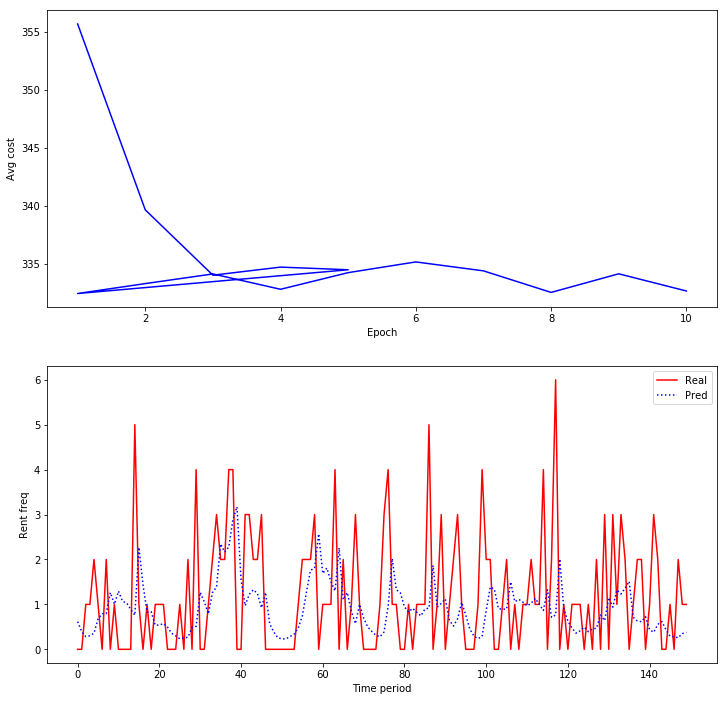

In [38]:
test_predict = sess.run(Y_pred, feed_dict={X: testX})
np.savetxt('lstm_demand_addweather2.csv', test_predict, delimiter=',', fmt='%f')    
# 테스트용 데이터 기준으로 측정지표 rmse를 산출한다
rmse_val = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
print("rmse: ", rmse_val)
    
    
fig = plt.figure()
fig.set_size_inches(12,12)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(iEpoch, iavgCost, 'b')
ax2.plot(testY[:150], 'r',label= 'Real')
ax2.plot(test_predict[:150], 'b:',label='Pred')

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Avg cost")

ax2.set_xlabel("Time period")
ax2.set_ylabel("Rent freq")
ax2.legend()
plt.show()

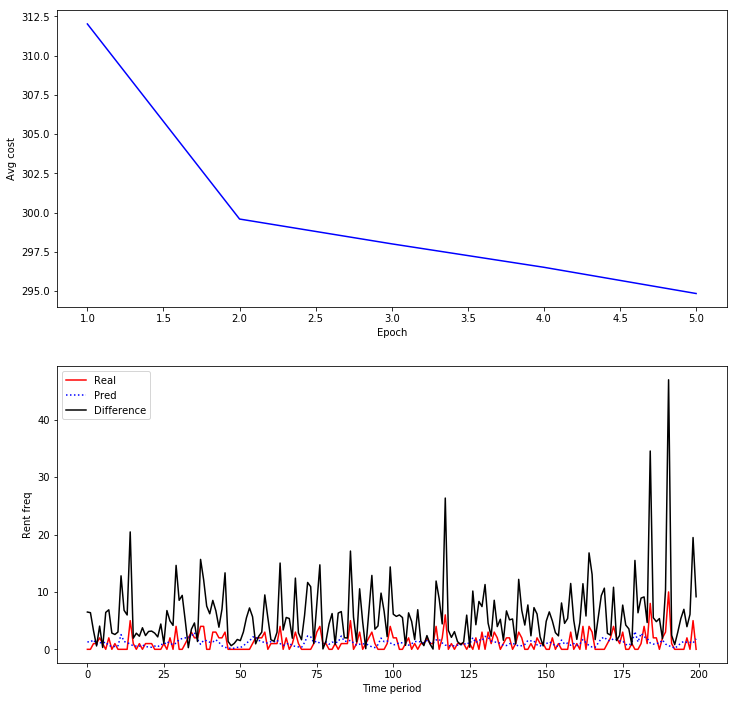

In [34]:
fig = plt.figure()
fig.set_size_inches(12,12)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(iEpoch, iavgCost, 'b')
ax2.plot(testY[0:200], 'r',label= 'Real')
ax2.plot(test_predict[4:204], 'b:',label='Pred')
ax2.plot(abs(testY[0:200] - test_predict[4:204])*5, 'k',label='Difference')

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Avg cost")

ax2.set_xlabel("Time period")
ax2.set_ylabel("Rent freq")
ax2.legend()
plt.show()